# Alanine Dipeptide Potential Energy with jaxmm

Evaluate the potential energy of alanine dipeptide (22 atoms, 66 DOF) using **jaxmm**,
a pure JAX replacement for OpenMM's energy evaluation.

**Two-step workflow:**
1. **One-time setup** (requires OpenMM): build the molecule, extract force field parameters.
2. **Runtime** (pure JAX): evaluate energy, compute gradients, run MD. No OpenMM dependency.

The energy is a sum of four terms: bond stretching, angle bending, torsion twisting,
and nonbonded interactions (Coulomb + Lennard-Jones). Because everything is pure JAX,
`jax.jit`, `jax.vmap`, and `jax.grad` all work out of the box.

The log-probability under the Boltzmann distribution is `log p(x) = -E(x) / (kB * T)`.
Higher log p = lower energy = more stable configuration.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)  # float64 required for jaxmm
import jax.numpy as jnp
import jax.random as random

import openmm
from openmm import unit
from openmmtools import testsystems

import jaxmm
from jaxmm import FEMTOSECOND, KB

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


## 1. Build molecule and extract parameters

openmmtools creates the alanine dipeptide system in vacuum with all degrees of freedom
unconstrained. `extract_params` reads the OpenMM System once, pulling out bond, angle,
torsion, and nonbonded parameters into frozen dataclasses of JAX arrays.

After extraction, OpenMM is no longer needed for energy evaluation.

In [2]:
# Alanine dipeptide in vacuum, all DOF free
temperature = 300.0  # K
aldp = testsystems.AlanineDipeptideVacuum(constraints=None)

# One-time parameter extraction (uses OpenMM)
params = jaxmm.extract_params(aldp.system)

print(f"Atoms: {params.n_atoms}, DOF: {params.n_atoms * 3}")
print(f"Bonds: {params.bonds.atom_i.shape[0]}")
print(f"Angles: {params.angles.atom_i.shape[0]}")
print(f"Torsions: {params.torsions.atom_i.shape[0]}")
print(f"Exclusion pairs: {params.nonbonded.exclusion_pairs.shape[0]}")
print(f"Exception pairs: {params.nonbonded.exception_pairs.shape[0]}")
print(f"GBSA: {'yes' if params.gbsa is not None else 'no'}")

Atoms: 22, DOF: 66
Bonds: 21
Angles: 36
Torsions: 52
Exclusion pairs: 57
Exception pairs: 41
GBSA: no


### Save/load parameters

`save_params` stores everything in a `.npz` file (no pickle). After saving,
you can load parameters on a machine without OpenMM installed.

In [3]:
save=False
if save:
    jaxmm.save_params(params, "aldp_vacuum_params.npz")
    params = jaxmm.load_params("aldp_vacuum_params.npz")
    print(f"Loaded: {params.n_atoms} atoms, GBSA: {params.gbsa is not None}")

## 2. Energy at minimized configuration

Extract the initial positions, minimize via L-BFGS (pure JAX), and evaluate
energy and log-Boltzmann factor.

In [4]:
# Initial positions from OpenMM (nm)
pos0 = jnp.array(aldp.positions.value_in_unit(unit.nanometer), dtype=jnp.float64)

# Energy-minimize via L-BFGS (pure JAX, same algorithm as OpenMM)
pos_min = jaxmm.minimize_energy(pos0, params)

energy = jaxmm.total_energy(pos_min, params)
lp = jaxmm.log_boltzmann(pos_min, params, temperature)
print(f"E(x_min) = {float(energy):.4f} kJ/mol")
print(f"log p(x_min) = {float(lp):.4f}")

E(x_min) = -118.4506 kJ/mol
log p(x_min) = 47.4878


## 3. Generate configurations via Langevin MD

jaxmm includes a Langevin BAOAB integrator (second-order, ergodic). The entire MD loop
is pure JAX: jittable, differentiable, GPU-compatible. No OpenMM at runtime.

We generate 500 frames, then evaluate log-Boltzmann factors on all of them
in a single vectorized call via `jax.vmap`.

In [5]:
n_frames = 500
save_every = 20
n_steps = n_frames * save_every  # 10000

# Run Langevin BAOAB from minimized configuration
result = jax.jit(
    jaxmm.langevin_baoab, static_argnames=("n_steps", "save_every")
)(
    pos_min, jnp.zeros_like(pos_min), params,
    dt=1.0 * FEMTOSECOND,  # 1 fs timestep
    temperature=temperature,  # 300 K
    friction=1.0,  # 1/ps
    n_steps=n_steps,
    save_every=save_every,
    key=random.key(42),
)

# MDTrajectory has named fields: .positions, .velocities,
# .trajectory_positions, .trajectory_velocities
traj = result.trajectory_positions
print(f"Trajectory: {traj.shape}  ({n_frames} frames x {params.n_atoms} atoms x 3)")

# Evaluate log-Boltzmann on all frames at once with vmap
vmap_log_boltzmann = jax.jit(jax.vmap(jaxmm.log_boltzmann, in_axes=(0, None, None)))
log_probs = vmap_log_boltzmann(traj, params, temperature)
print(f"log p range: [{float(log_probs.min()):.1f}, {float(log_probs.max()):.1f}]")

Trajectory: (500, 22, 3)  (500 frames x 22 atoms x 3)
log p range: [5.6, 47.1]


## 4. Ramachandran plot

The interesting behavior of alanine dipeptide is captured by two backbone dihedral
angles, **phi** and **psi** (both -180 to +180 degrees). Different regions of the
phi/psi plane correspond to distinct stable conformations.

`jaxmm.dihedral_angle` computes these directly from positions (pure JAX, batched).

**Left**: each frame colored by log-probability. Bright = low energy = stable.
**Right**: 2D histogram of where the molecule spends time.

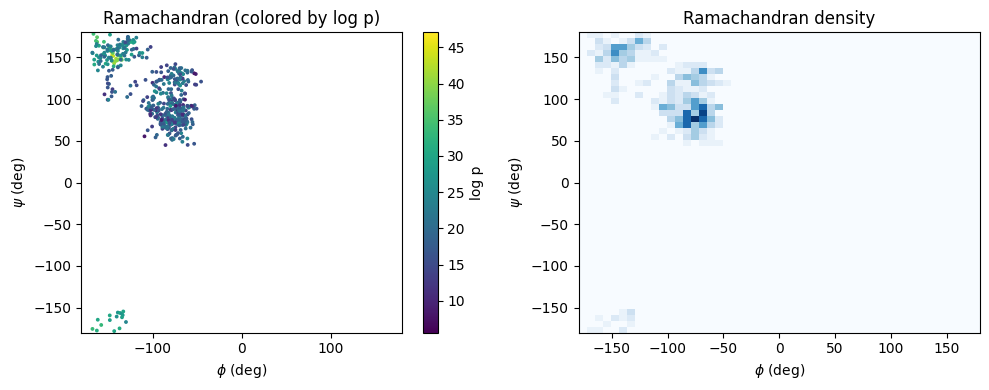

In [6]:
# Backbone dihedral indices from the topology
phi_idx = jnp.array(jaxmm.phi_indices(aldp.topology))
psi_idx = jnp.array(jaxmm.psi_indices(aldp.topology))

# Compute phi/psi for all frames (batched, pure JAX)
phi = jaxmm.dihedral_angle(traj, phi_idx)
psi = jaxmm.dihedral_angle(traj, psi_idx)

# ALDP has one phi and one psi angle
phi_deg = np.degrees(np.array(phi[:, 0]))
psi_deg = np.degrees(np.array(psi[:, 0]))
log_probs_np = np.array(log_probs)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sc = axes[0].scatter(phi_deg, psi_deg, c=log_probs_np, s=3, cmap="viridis")
axes[0].set_xlabel(r"$\phi$ (deg)")
axes[0].set_ylabel(r"$\psi$ (deg)")
axes[0].set_title("Ramachandran (colored by log p)")
axes[0].set_xlim(-180, 180)
axes[0].set_ylim(-180, 180)
plt.colorbar(sc, ax=axes[0], label="log p")

axes[1].hist2d(phi_deg, psi_deg, bins=50,
               range=[[-180, 180], [-180, 180]], cmap="Blues")
axes[1].set_xlabel(r"$\phi$ (deg)")
axes[1].set_ylabel(r"$\psi$ (deg)")
axes[1].set_title("Ramachandran density")

plt.tight_layout()
plt.show()

## 5. Energy along the trajectory

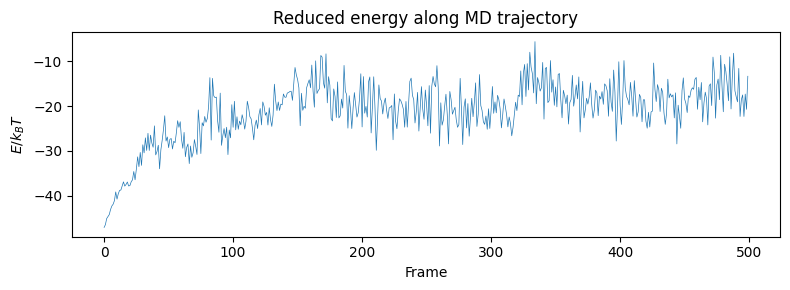

In [7]:
reduced_energies = -np.array(log_probs)  # E / kBT

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(reduced_energies, lw=0.5)
ax.set_xlabel("Frame")
ax.set_ylabel(r"$E / k_B T$")
ax.set_title("Reduced energy along MD trajectory")
plt.tight_layout()
plt.show()

## 6. Per-term energy breakdown

`energy_components` returns a dict of per-term energies, computed efficiently
with a shared distance matrix. We vmap it across all frames to see which
contributions dominate along the trajectory.

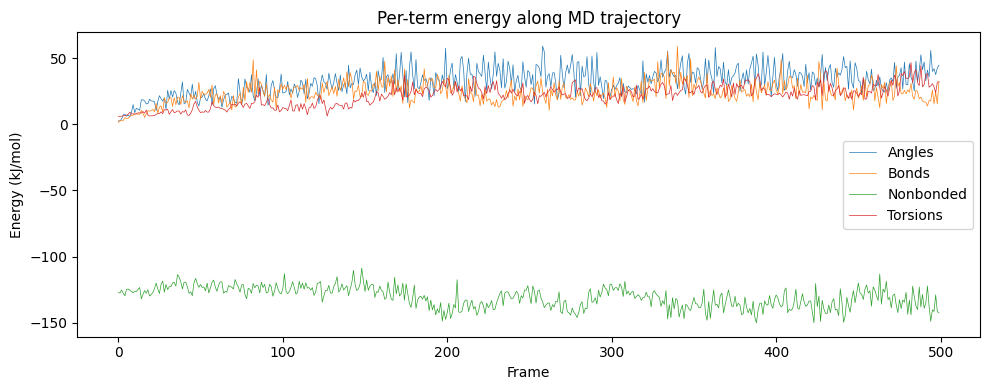

In [8]:
# Vectorized per-term decomposition using energy_components
vmap_components = jax.jit(jax.vmap(jaxmm.energy_components, in_axes=(0, None)))
comp = vmap_components(traj, params)

fig, ax = plt.subplots(figsize=(10, 4))
for name, values in comp.items():
    ax.plot(np.array(values), lw=0.5, label=name.capitalize())
ax.set_xlabel("Frame")
ax.set_ylabel("Energy (kJ/mol)")
ax.set_title("Per-term energy along MD trajectory")
ax.legend()
plt.tight_layout()
plt.show()

## 7. Forces via jax.grad

Because jaxmm energy functions are pure JAX, forces (negative gradient of energy)
come for free via automatic differentiation. No finite differences needed.

In [9]:
grad_fn = jax.jit(jax.grad(jaxmm.total_energy))

# Forces at the minimized configuration
forces = -grad_fn(pos_min, params)
force_magnitudes = jnp.linalg.norm(forces, axis=-1)

print(f"Force magnitudes (kJ/mol/nm) at minimized config:")
print(f"  min:  {float(force_magnitudes.min()):.4f}")
print(f"  max:  {float(force_magnitudes.max()):.4f}")
print(f"  mean: {float(force_magnitudes.mean()):.4f}")
print(f"(Small forces at a minimum, as expected.)")

Force magnitudes (kJ/mol/nm) at minimized config:
  min:  0.2470
  max:  2.4922
  mean: 1.4042
(Small forces at a minimum, as expected.)
